In [ ]:
!pip install medpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 14.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Task01_BrainTumour.tar" .


In [ ]:
###################################
# Extract the tar file
###################################
import tarfile
import os

# Define the file path
tar_file_path = './Task01_BrainTumour.tar'
extract_path = './Task01_BrainTumour'

# Extract the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path=extract_path)

print("Extraction completed!")


Extraction completed!


In [ ]:
import os
print(os.listdir('./Task01_BrainTumour'))

['Task01_BrainTumour']


# ITK SNAP software
##  Visualize MRI slice with mask overlay

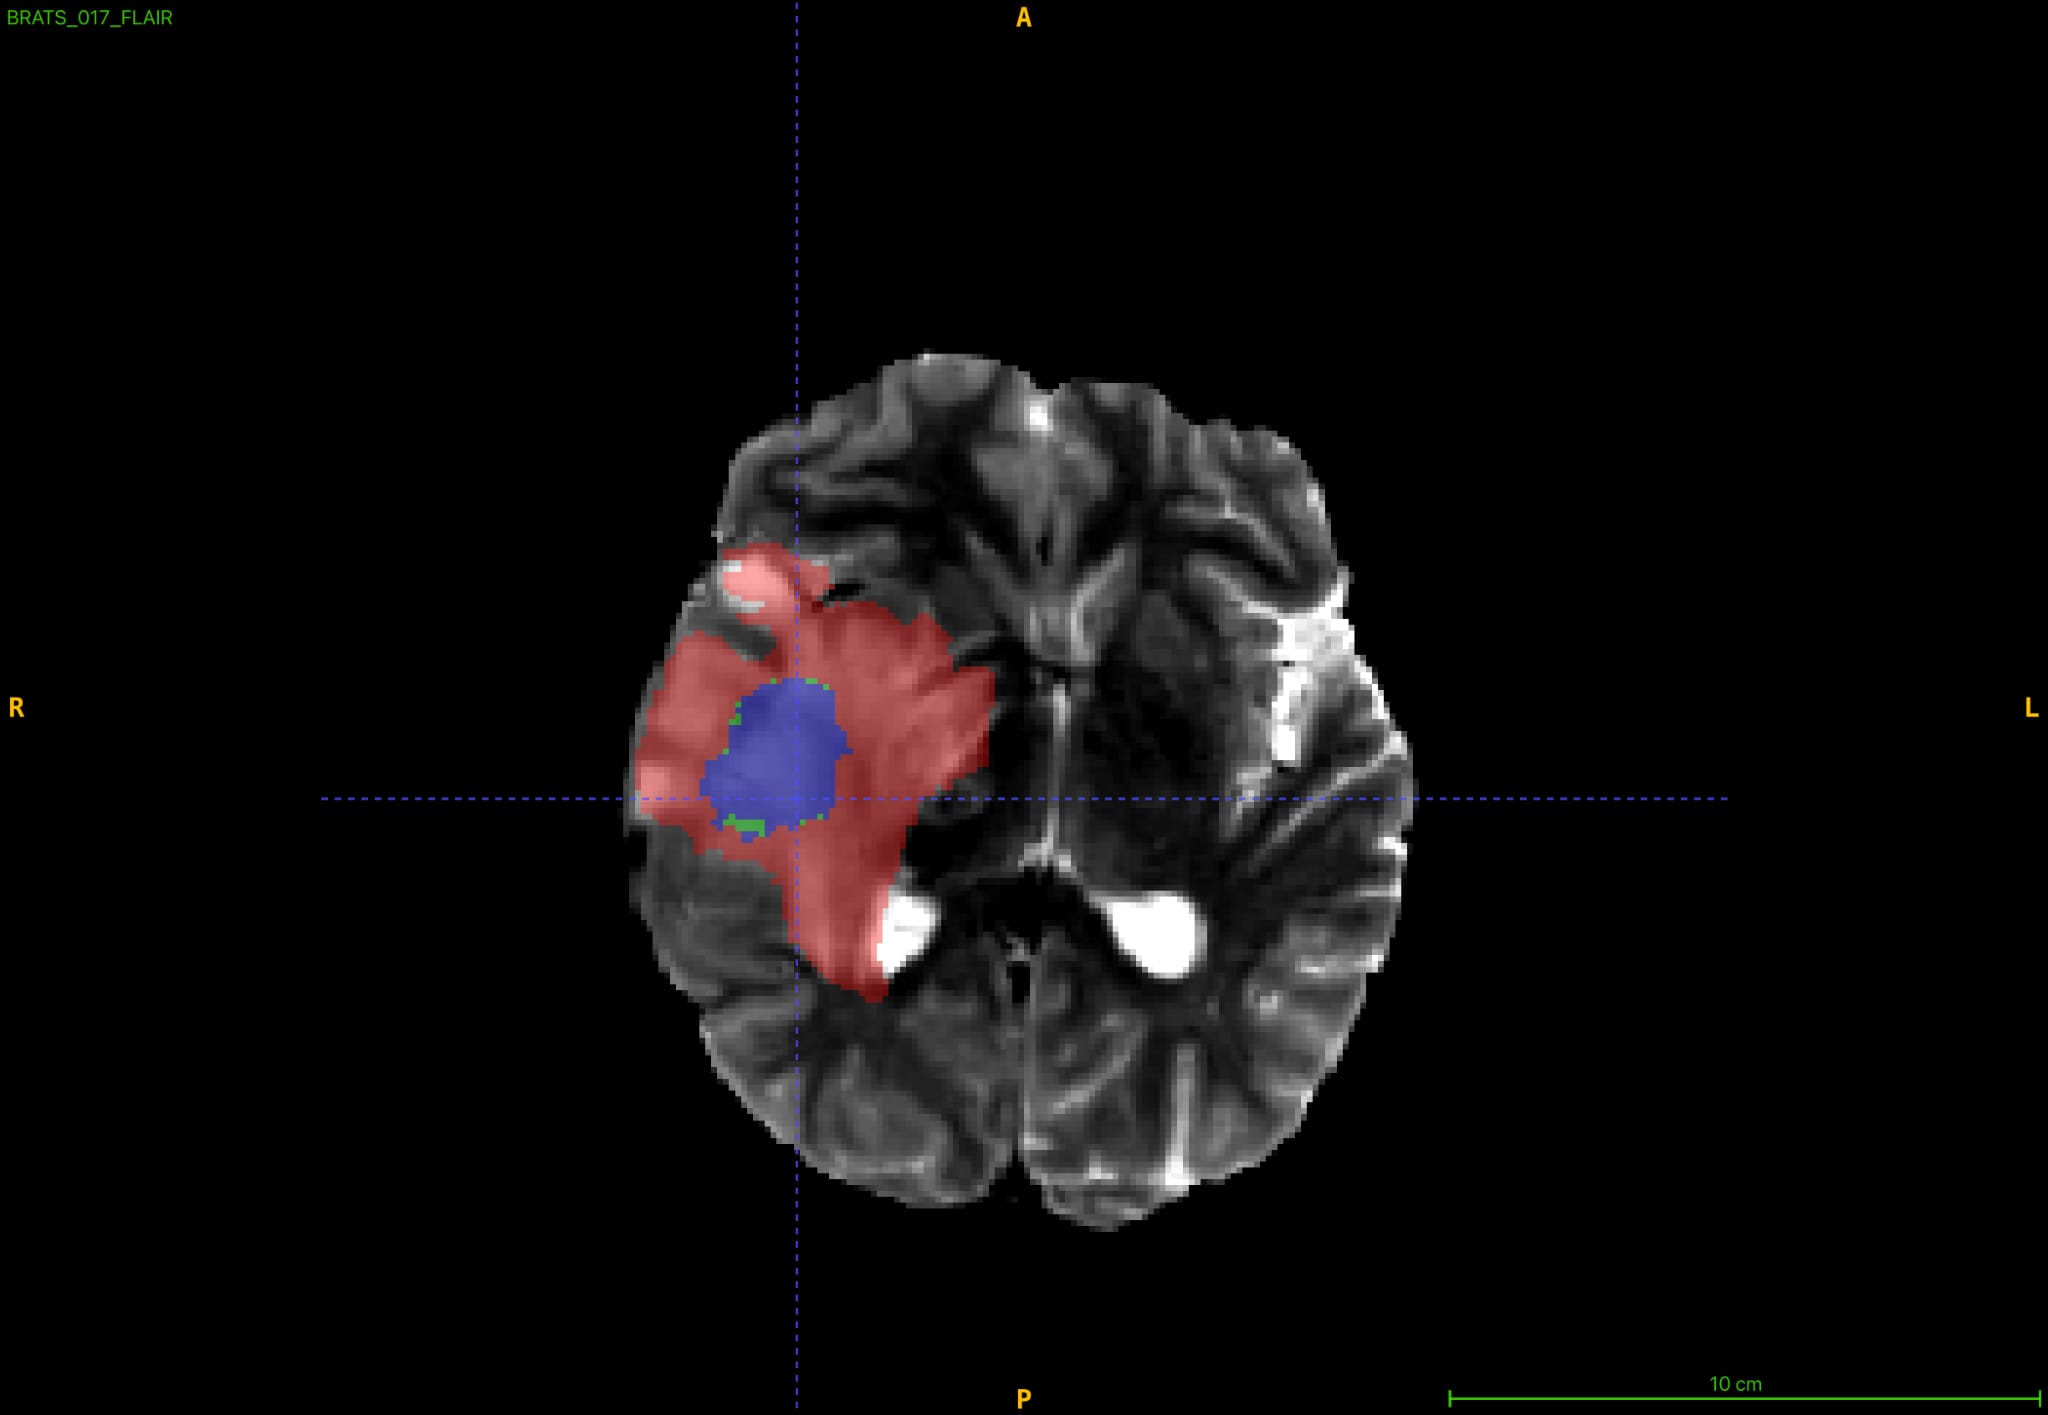

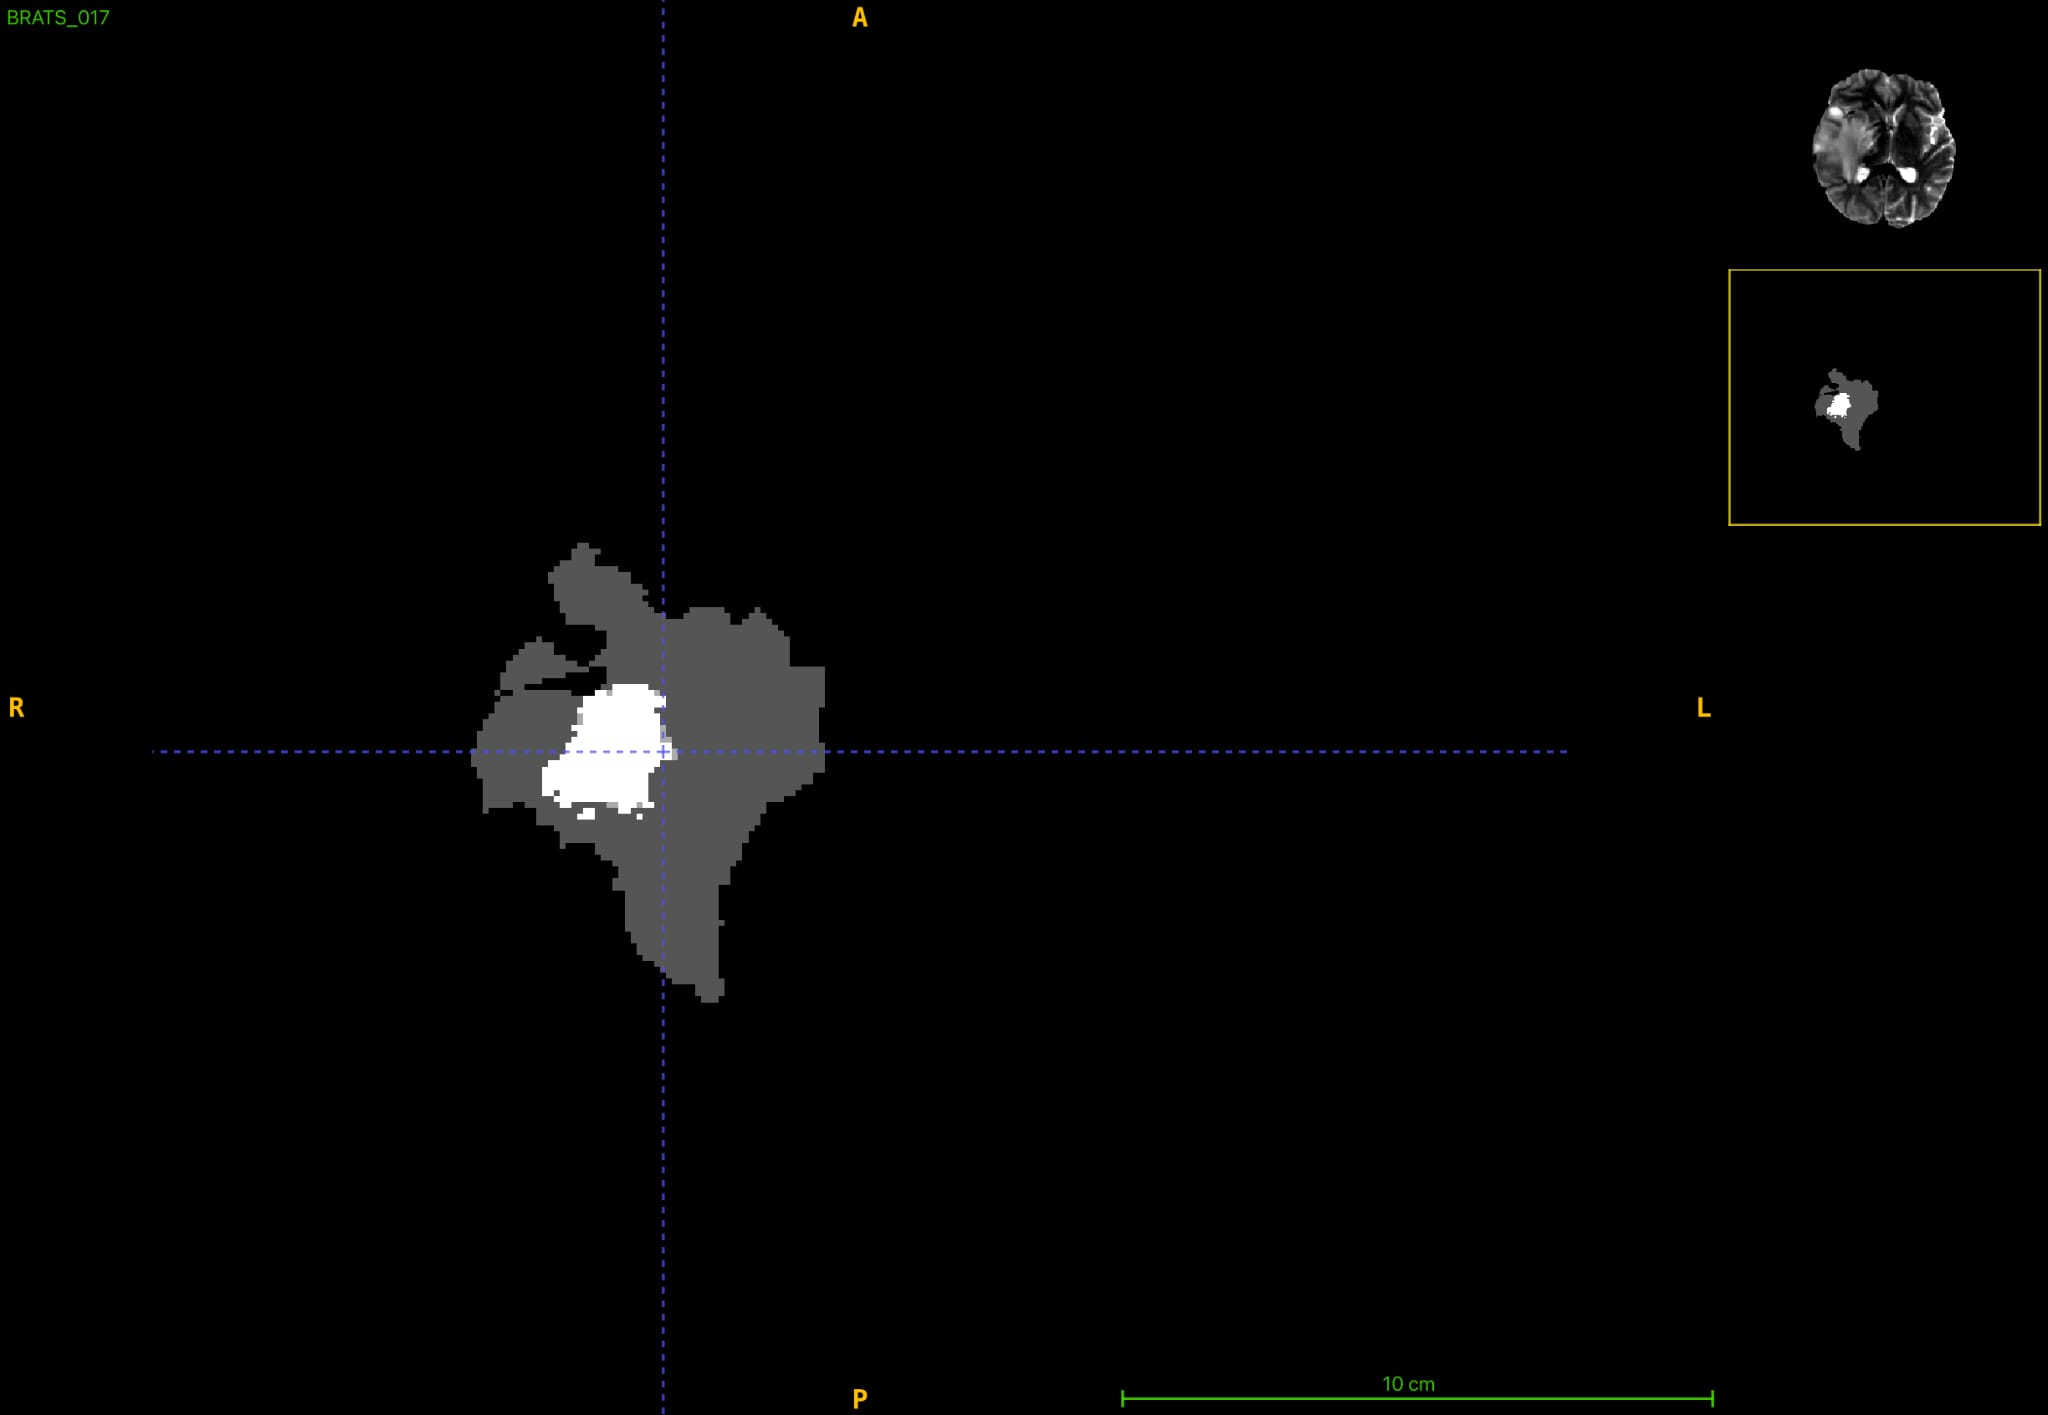

# Task 2
## 2) Brain tumor segmentation using U-Net - Using 2D U-Net(process MRI slice by slice)

In [ ]:
##################################
# Imports and Setup
##################################
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from medpy.metric import binary
from tqdm import tqdm

# Trying to run the code in DEMO_MODE to True to use only a subset of the data and fewer epochs.
DEMO_MODE = True
if DEMO_MODE:
    MAX_SUBJECTS = 50
    NUM_EPOCHS = 3
    NUM_FOLDS = 5
    print("MAX Subjects select is True use minimal data")
else:
    MAX_SUBJECTS = None  # Use all subjects
    NUM_EPOCHS = 20
    NUM_FOLDS = 5
    print("MAX Subjects select is None")

print("All imports loaded successfully!")


MAX Subjects select is True use minimal data
All imports loaded successfully!


In [ ]:
import torch
torch.cuda.empty_cache()  # Clears unused GPU memory
print("GPU cache cleared.")

GPU cache cleared.


In [ ]:
##################################
# Created U-Net Model Definition
# Two consecutive convolutional layers with BatchNorm and ReLU.
##################################
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

#     A 2D U-Net model for multi-class segmentation. Default out_channels=5 for:
#       0=background, 1=necrotic & non-enhancing, 2=edema, 3=(unused), 4=enhancing tumor

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=5, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Down-sampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Up-sampling path (reverse order)
        rev_features = features[::-1]
        for feature in rev_features:
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final 1x1 convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skipConnections = []
        for down in self.downs:
            x = down(x)
            skipConnections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.bottleneck(x)
        skipConnections = skipConnections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skipConnections = skipConnections[idx // 2]
            if x.shape != skipConnections.shape:
                x = F.interpolate(x, size=skipConnections.shape[2:])
            x = torch.cat((skipConnections, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

print("U-Net model definition loaded successfully!")


U-Net model definition loaded successfully!


In [ ]:
##################################
# Creating BraTS Dataset (2D Slices)
#Reads a list of 3D MRI volumes (and corresponding segmentation masks), and returns individual axial slices as 2D samples.
# If the image data is 4D (H, W, D, modalities), the slice is transposed to (modalities, H, W).
##################################
class BraTSDataset2D(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

        self.slice_indices = []
        for img_path, lbl_path in zip(self.image_paths, self.label_paths):
            img_data = nib.load(img_path).get_fdata()
            if img_data.ndim == 4:
                num_slices = img_data.shape[2]
            else:
                num_slices = img_data.shape[2]
            for i in range(num_slices):
                self.slice_indices.append((img_path, lbl_path, i))

    def __len__(self):
        return len(self.slice_indices)

    def __getitem__(self, idx):
        img_path, lbl_path, slice_idx = self.slice_indices[idx]
        img_data = nib.load(img_path).get_fdata()
        lbl_data = nib.load(lbl_path).get_fdata()

        # If image is multi-modal (4D): shape (H, W, D, modalities)
        if img_data.ndim == 4:
            # Extract the slice: shape (H, W, modalities)
            image = img_data[:, :, slice_idx, :]
            # Transpose to (modalities, H, W)
            image = np.transpose(image, (2, 0, 1))
        else:
            image = img_data[:, :, slice_idx]
            image = np.expand_dims(image, axis=0)

        # For labels, assume 3D (H, W, D) and extract a 2D slice.
        label = lbl_data[:, :, slice_idx]

        # Normalize image per slice (across all modalities)
        image = (image - np.mean(image)) / (np.std(image) + 1e-8)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        if self.transform:
            image, label = self.transform(image, label)

        return image, label

print("BraTSDataset2D class loaded successfully!")


BraTSDataset2D class loaded successfully!


**************Training Subject functions loaded successfully!********************
**************Evaluating the best model done********************
Using device: cuda
Found 484 image files.
Found 484 label files.
Demo mode: Using only 50 subjects.
Model will use 4 input channels.

=== Fold 1/5 ===
Epoch 1/3


  Train Loss: 0.2642 | Val WT Dice: 0.7498
Epoch 2/3


  Train Loss: 0.0270 | Val WT Dice: 0.7765
Epoch 3/3


  Train Loss: 0.0156 | Val WT Dice: 0.8046
Fold 1 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7362801035015676, 'HD95': 5.074981379740283}, 'WT': {'Dice': 0.8046075112418354, 'HD95': 3.935190716778688}}

=== Fold 2/5 ===
Epoch 1/3


  Train Loss: 0.2680 | Val WT Dice: 0.7333
Epoch 2/3


  Train Loss: 0.0298 | Val WT Dice: 0.7808
Epoch 3/3


  Train Loss: 0.0169 | Val WT Dice: 0.7401
Fold 2 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7111905799542414, 'HD95': 3.6711066979358575}, 'WT': {'Dice': 0.7401238216580187, 'HD95': 3.361440661812969}}

=== Fold 3/5 ===
Epoch 1/3


  Train Loss: 0.2310 | Val WT Dice: 0.6946
Epoch 2/3


  Train Loss: 0.0290 | Val WT Dice: 0.7008
Epoch 3/3


  Train Loss: 0.0169 | Val WT Dice: 0.6931
Fold 3 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.6588379027910655, 'HD95': 8.039144046793197}, 'WT': {'Dice': 0.6930528961172704, 'HD95': 8.219201025488633}}

=== Fold 4/5 ===
Epoch 1/3


  Train Loss: 0.2069 | Val WT Dice: 0.7881
Epoch 2/3


  Train Loss: 0.0278 | Val WT Dice: 0.7864
Epoch 3/3


  Train Loss: 0.0170 | Val WT Dice: 0.8194
Fold 4 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7838597237774341, 'HD95': 4.1335908785957205}, 'WT': {'Dice': 0.8194145766371105, 'HD95': 3.6775300751898636}}

=== Fold 5/5 ===
Epoch 1/3


  Train Loss: 0.2801 | Val WT Dice: 0.6924
Epoch 2/3


  Train Loss: 0.0334 | Val WT Dice: 0.7708
Epoch 3/3


  Train Loss: 0.0186 | Val WT Dice: 0.8249
Fold 5 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.820198720177531, 'HD95': 4.203328679777469}, 'WT': {'Dice': 0.8249455495796287, 'HD95': 3.6960081256478587}}

Summary of Cross Validation Results:
Fold	ET Dice	ET HD95	TC Dice	TC HD95	WT Dice	WT HD95
1	1.0000	0.0000	0.7363	5.0750	0.8046	3.9352
2	1.0000	0.0000	0.7112	3.6711	0.7401	3.3614
3	1.0000	0.0000	0.6588	8.0391	0.6931	8.2192
4	1.0000	0.0000	0.7839	4.1336	0.8194	3.6775
5	1.0000	0.0000	0.8202	4.2033	0.8249	3.6960

Average Results (across folds):
ET Dice: 1.0000, ET HD95: 0.0000
TC Dice: 0.7421, TC HD95: 5.0244
WT Dice: 0.7764, WT HD95: 4.5779
fOR EVALUATION Model will use 4 input channels.
Loading best model from: best_model_fold5.pth


<ipython-input-10-d51ac730cab4>:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


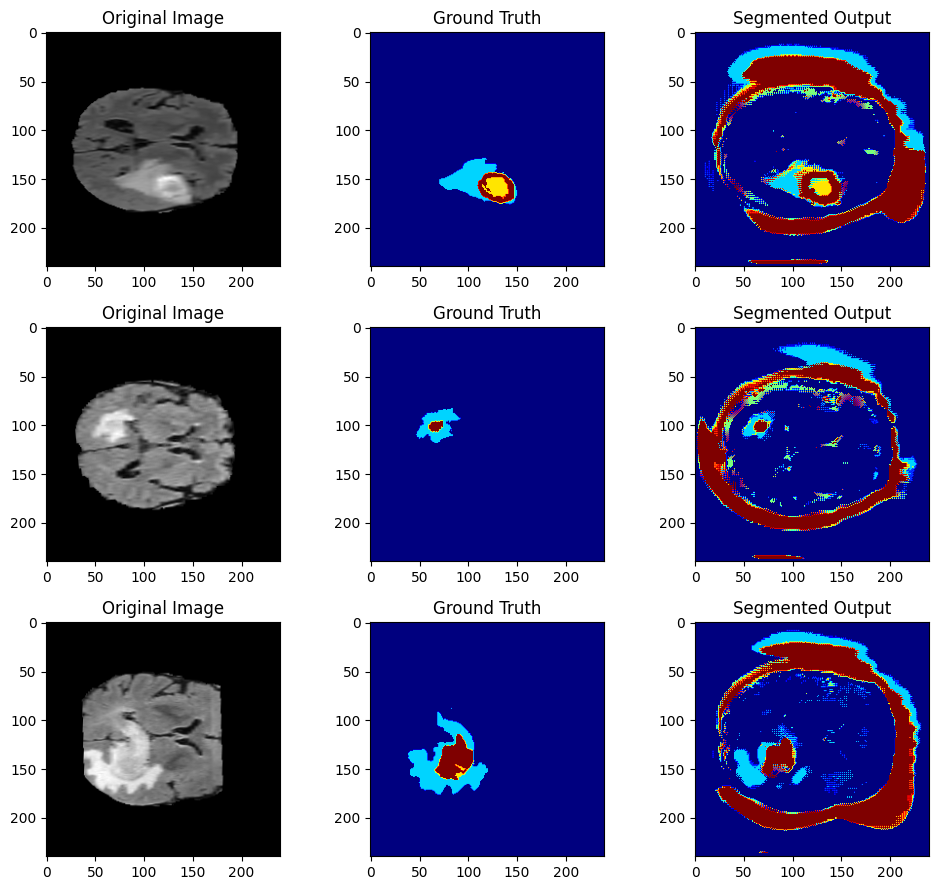

In [ ]:
# if DEMO_MODE:
#     MAX_SUBJECTS = 50  # Use only 50 subjects
#     NUM_EPOCHS = 5   # Fewer epochs for quick demo
#     NUM_FOLDS = 5   # Use  folds 5
#     print("MAX Subjects select is True use minimal data")
##################################
# Training & 5-Fold Cross Validation   -
##################################

def visualizeSegmentations_Details(model, sample_images, sample_labels, device):
    model.eval()
    fig, axes = plt.subplots(len(sample_images), 3, figsize=(10, len(sample_images) * 3))

    with torch.no_grad():
        for i, (img_path, label_path) in enumerate(zip(sample_images, sample_labels)):
            image_nib = nib.load(img_path)
            label_nib = nib.load(label_path)
            image = image_nib.get_fdata()
            label = label_nib.get_fdata()

            # Check image dimensions and adjust accordingly
            if image.ndim == 4:  # Shape: (H, W, D, C)
                mid_slice = image.shape[2] // 2  # Extract middle slice
                image_slice = image[:, :, mid_slice, :]  # Shape: (H, W, C)
                label_slice = label[:, :, mid_slice]  # Shape: (H, W)
                image_tensor = torch.tensor(image_slice, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
            elif image.ndim == 3:  # Shape: (H, W, D) (Single channel 3D image)
                mid_slice = image.shape[2] // 2  # Extract middle slice
                image_slice = image[:, :, mid_slice]  # Shape: (H, W)
                label_slice = label[:, :, mid_slice]  # Shape: (H, W)
                image_tensor = torch.tensor(image_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            else:
                raise ValueError(f"Unexpected image dimensions: {image.shape}")

            # Forward pass through the model (REMOVED .unsqueeze(0))
            pred = model(image_tensor)  # Correct: image_tensor is already [1, C, H, W]
            pred = torch.argmax(pred, dim=1).cpu().numpy()[0]  # Convert to numpy

            # Plot the final images
            axes[i, 0].imshow(image_slice if image_slice.ndim == 2 else image_slice[:, :, 0], cmap='gray')
            axes[i, 0].set_title("Original Image")

            axes[i, 1].imshow(label_slice, cmap='jet')
            axes[i, 1].set_title("Ground Truth")

            axes[i, 2].imshow(pred, cmap='jet')
            axes[i, 2].set_title("Segmented Output")

    plt.tight_layout()
    plt.show()

def computeMetricsValues(pred, target):
    metrics = {}
    pred_et = (pred == 4).astype(np.uint8)
    target_et = (target == 4).astype(np.uint8)
    pred_tc = np.isin(pred, [1, 4]).astype(np.uint8)
    target_tc = np.isin(target, [1, 4]).astype(np.uint8)
    pred_wt = np.isin(pred, [1, 2, 4]).astype(np.uint8)
    target_wt = np.isin(target, [1, 2, 4]).astype(np.uint8)

    # Dice calculation with NumPy
    def numpy_dice(p, t, smooth=1e-5):
        intersection = (p * t).sum()
        return (2. * intersection + smooth) / (p.sum() + t.sum() + smooth)

    dice_et = numpy_dice(pred_et, target_et)
    dice_tc = numpy_dice(pred_tc, target_tc)
    dice_wt = numpy_dice(pred_wt, target_wt)

    # here the HD95 calculation with empty mask checks
    def sa_hd95(pred_mask, target_mask):
        if pred_mask.sum() == 0 and target_mask.sum() == 0:
            return 0.0
        elif pred_mask.sum() == 0 or target_mask.sum() == 0:
            return np.nan
        else:
            return binary.hd95(pred_mask, target_mask)

    hd_et = sa_hd95(pred_et, target_et)
    hd_tc = sa_hd95(pred_tc, target_tc)
    hd_wt = sa_hd95(pred_wt, target_wt)

    metrics['ET'] = {'Dice': dice_et, 'HD95': hd_et}
    metrics['TC'] = {'Dice': dice_tc, 'HD95': hd_tc}
    metrics['WT'] = {'Dice': dice_wt, 'HD95': hd_wt}
    return metrics

def trainModelFunction(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader, desc="Training Batches", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate_model(model, dataloader, device):
    model.eval()
    all_metrics = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = labels.numpy()
            for pred, target in zip(preds, targets):
                m = computeMetricsValues(pred, target)
                all_metrics.append(m)

    avg_metrics = {'ET': {'Dice': 0, 'HD95': 0},
                   'TC': {'Dice': 0, 'HD95': 0},
                   'WT': {'Dice': 0, 'HD95': 0}}
    n = len(all_metrics)
    for m in all_metrics:
        for region in avg_metrics.keys():
            avg_metrics[region]['Dice'] += m[region]['Dice']
            avg_metrics[region]['HD95'] += m[region]['HD95'] if not np.isnan(m[region]['HD95']) else 0
    for region in avg_metrics.keys():
        avg_metrics[region]['Dice'] /= n
        avg_metrics[region]['HD95'] /= n
    return avg_metrics

# fold_results = []
model = None
val_image_paths= []
val_label_paths=[]
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run5foldTraining():
    global model, fold_results, val_image_paths, val_label_paths, device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    imagesTr_dir = r"content/Task01_BrainTumour/imagesTr"
    labelsTr_dir = r"content/Task01_BrainTumour/labelsTr"

    image_paths = sorted(glob.glob(os.path.join(imagesTr_dir, '*.nii*')))
    label_paths = sorted(glob.glob(os.path.join(labelsTr_dir, '*.nii*')))

    print("Found", len(image_paths), "image files.")
    print("Found", len(label_paths), "label files.")

    subjects = list(zip(image_paths, label_paths))

    if len(subjects) == 0:
        raise ValueError("No subjects found. Please check your dataset paths and file extensions.")

    if MAX_SUBJECTS is not None and len(subjects) > MAX_SUBJECTS:
        subjects = subjects[:MAX_SUBJECTS]
        print(f"Demo mode: Using only {MAX_SUBJECTS} subjects.")


    kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_results = []

    # Determine input channels from first image:
    sample_data = nib.load(image_paths[0]).get_fdata()
    if sample_data.ndim == 4:
        in_channels = sample_data.shape[-1]
    else:
        in_channels = 1
    print("Model will use", in_channels, "input channels.")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(subjects)):
        print(f"\n=== Fold {fold+1}/{NUM_FOLDS} ===")
        train_subjects = [subjects[i] for i in train_idx]
        val_subjects = [subjects[i] for i in val_idx]

        train_image_paths = [s[0] for s in train_subjects]
        train_label_paths = [s[1] for s in train_subjects]
        val_image_paths = [s[0] for s in val_subjects]
        val_label_paths = [s[1] for s in val_subjects]

        train_dataset = BraTSDataset2D(train_image_paths, train_label_paths)
        val_dataset = BraTSDataset2D(val_image_paths, val_label_paths)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

        model = UNet(in_channels=in_channels, out_channels=5).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        best_val_dice = 0.0

        for epoch in range(NUM_EPOCHS):
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
            train_loss = trainModelFunction(model, train_loader, optimizer, criterion, device)
            val_metrics = evaluate_model(model, val_loader, device)
            val_wt_dice = val_metrics['WT']['Dice']
            print(f"  Train Loss: {train_loss:.4f} | Val WT Dice: {val_wt_dice:.4f}")

            if val_wt_dice > best_val_dice:
                best_val_dice = val_wt_dice
                torch.save(model.state_dict(), f"best_model_fold{fold+1}.pth")

        final_metrics = evaluate_model(model, val_loader, device)
        fold_results.append(final_metrics)
        print(f"Fold {fold+1} final metrics:", final_metrics)

        # Clear memory after each fold
        del model, optimizer, criterion
        torch.cuda.empty_cache()
        gc.collect()

    print("\nSummary of Cross Validation Results:")
    print("Fold\tET Dice\tET HD95\tTC Dice\tTC HD95\tWT Dice\tWT HD95")
    for i, res in enumerate(fold_results):
        print(f"{i+1}\t"
              f"{res['ET']['Dice']:.4f}\t{res['ET']['HD95']:.4f}\t"
              f"{res['TC']['Dice']:.4f}\t{res['TC']['HD95']:.4f}\t"
              f"{res['WT']['Dice']:.4f}\t{res['WT']['HD95']:.4f}")

    avg_results = {'ET': {'Dice': 0, 'HD95': 0},
                   'TC': {'Dice': 0, 'HD95': 0},
                   'WT': {'Dice': 0, 'HD95': 0}}
    for res in fold_results:
        for region in avg_results.keys():
            avg_results[region]['Dice'] += res[region]['Dice']
            avg_results[region]['HD95'] += res[region]['HD95']
    for region in avg_results.keys():
        avg_results[region]['Dice'] /= len(fold_results)
        avg_results[region]['HD95'] /= len(fold_results)

    print("\nAverage Results (across folds):")
    print(f"ET Dice: {avg_results['ET']['Dice']:.4f}, ET HD95: {avg_results['ET']['HD95']:.4f}")
    print(f"TC Dice: {avg_results['TC']['Dice']:.4f}, TC HD95: {avg_results['TC']['HD95']:.4f}")
    print(f"WT Dice: {avg_results['WT']['Dice']:.4f}, WT HD95: {avg_results['WT']['HD95']:.4f}")


    # Determine input channels from first image:
    sample_data = nib.load(image_paths[0]).get_fdata()
    if sample_data.ndim == 4:
        in_channels = sample_data.shape[-1]
    else:
        in_channels = 1
    print("fOR EVALUATION Model will use", in_channels, "input channels.")

    # Update based on best fold
    sample_images = image_paths[:3]  # Selecting first three images for demonstration
    sample_labels = label_paths[:3]  # Corresponding ground truth labels
    #  Find the best-performing fold (highest WT Dice score)
    best_fold_idx = np.argmax([res['WT']['Dice'] for res in fold_results]) + 1  # 1-based indexing

    best_model_path = f"best_model_fold{best_fold_idx}.pth"  # Use best fold checkpoint
    print(f"Loading best model from: {best_model_path}")

    model = UNet(in_channels=in_channels, out_channels=5).to(device)
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    visualizeSegmentations_Details(model, sample_images, sample_labels, device)

print("**************Training Subject functions loaded successfully!********************")
print("**************Evaluating the best model done********************")

# calling the function to execute
run5foldTraining()

#Batch Size = 12 ----> Epoch 10 ---> 5 fold and 50 Images Results executed with Same code different parameter values




In [ ]:
# **************Training Subject functions loaded successfully!********************
# **************Evaluating the best model done********************
# Using device: cuda
# Found 484 image files.
# Found 484 label files.
# Demo mode: Using only 50 subjects.
# Model will use 4 input channels.

# === Fold 1/5 ===
# Epoch 1/10

#   Train Loss: 0.6635 | Val WT Dice: 0.6992
# Epoch 2/10

#   Train Loss: 0.1756 | Val WT Dice: 0.7586
# Epoch 3/10

#   Train Loss: 0.0740 | Val WT Dice: 0.8001
# Epoch 4/10

#   Train Loss: 0.0419 | Val WT Dice: 0.7938
# Epoch 5/10

#   Train Loss: 0.0269 | Val WT Dice: 0.7441
# Epoch 6/10

#   Train Loss: 0.0198 | Val WT Dice: 0.8117
# Epoch 7/10

#   Train Loss: 0.0164 | Val WT Dice: 0.8012
# Epoch 8/10

#   Train Loss: 0.0132 | Val WT Dice: 0.6257
# Epoch 9/10

#   Train Loss: 0.0122 | Val WT Dice: 0.8202
# Epoch 10/10

#   Train Loss: 0.0104 | Val WT Dice: 0.8064
# Fold 1 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7337298786358288, 'HD95': 4.644375334141041}, 'WT': {'Dice': 0.8064249191205853, 'HD95': 3.8244368141501446}}

# === Fold 2/5 ===
# Epoch 1/10

#   Train Loss: 0.6243 | Val WT Dice: 0.6558
# Epoch 2/10

#   Train Loss: 0.1507 | Val WT Dice: 0.7419
# Epoch 3/10

#   Train Loss: 0.0634 | Val WT Dice: 0.7802
# Epoch 4/10

#   Train Loss: 0.0371 | Val WT Dice: 0.7375
# Epoch 5/10

#   Train Loss: 0.0251 | Val WT Dice: 0.7947
# Epoch 6/10

#   Train Loss: 0.0190 | Val WT Dice: 0.8166
# Epoch 7/10

#   Train Loss: 0.0150 | Val WT Dice: 0.8196
# Epoch 8/10

#   Train Loss: 0.0123 | Val WT Dice: 0.8350
# Epoch 9/10

#   Train Loss: 0.0108 | Val WT Dice: 0.7896
# Epoch 10/10

#   Train Loss: 0.0095 | Val WT Dice: 0.8180
# Fold 2 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.79212008921154, 'HD95': 3.16843707209019}, 'WT': {'Dice': 0.8180109042734472, 'HD95': 2.833116758250285}}

# === Fold 3/5 ===
# Epoch 1/10

#   Train Loss: 0.5622 | Val WT Dice: 0.7547
# Epoch 2/10

#   Train Loss: 0.1447 | Val WT Dice: 0.7666
# Epoch 3/10

#   Train Loss: 0.0608 | Val WT Dice: 0.7674
# Epoch 4/10

#   Train Loss: 0.0348 | Val WT Dice: 0.7299
# Epoch 5/10

#   Train Loss: 0.0236 | Val WT Dice: 0.7928
# Epoch 6/10

#   Train Loss: 0.0173 | Val WT Dice: 0.8010
# Epoch 7/10

#   Train Loss: 0.0142 | Val WT Dice: 0.8526
# Epoch 8/10

#   Train Loss: 0.0122 | Val WT Dice: 0.8660
# Epoch 9/10

#   Train Loss: 0.0103 | Val WT Dice: 0.8235
# Epoch 10/10

#   Train Loss: 0.0093 | Val WT Dice: 0.8488
# Fold 3 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7934229538279489, 'HD95': 4.050237832898032}, 'WT': {'Dice': 0.848829477530744, 'HD95': 3.6712720113998945}}

# === Fold 4/5 ===
# Epoch 1/10

#   Train Loss: 0.4811 | Val WT Dice: 0.7604
# Epoch 2/10

#   Train Loss: 0.1194 | Val WT Dice: 0.8059
# Epoch 3/10

#   Train Loss: 0.0505 | Val WT Dice: 0.8059
# Epoch 4/10

#   Train Loss: 0.0304 | Val WT Dice: 0.8337
# Epoch 5/10

#   Train Loss: 0.0213 | Val WT Dice: 0.8311
# Epoch 6/10

#   Train Loss: 0.0170 | Val WT Dice: 0.8424
# Epoch 7/10

#   Train Loss: 0.0136 | Val WT Dice: 0.8551
# Epoch 8/10

#   Train Loss: 0.0121 | Val WT Dice: 0.8521
# Epoch 9/10

#   Train Loss: 0.0104 | Val WT Dice: 0.8524
# Epoch 10/10

#   Train Loss: 0.0095 | Val WT Dice: 0.8490
# Fold 4 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.8198657459782569, 'HD95': 4.040726300049948}, 'WT': {'Dice': 0.8490429947117566, 'HD95': 3.7658401562814516}}

# === Fold 5/5 ===
# Epoch 1/10

#   Train Loss: 0.6254 | Val WT Dice: 0.7698
# Epoch 2/10

#   Train Loss: 0.1622 | Val WT Dice: 0.7315
# Epoch 3/10

#   Train Loss: 0.0663 | Val WT Dice: 0.8055
# Epoch 4/10

#   Train Loss: 0.0360 | Val WT Dice: 0.8240
# Epoch 5/10

#   Train Loss: 0.0253 | Val WT Dice: 0.8023
# Epoch 6/10

#   Train Loss: 0.0187 | Val WT Dice: 0.8216
# Epoch 7/10

#   Train Loss: 0.0147 | Val WT Dice: 0.8486
# Epoch 8/10

#   Train Loss: 0.0129 | Val WT Dice: 0.8407
# Epoch 9/10

#   Train Loss: 0.0112 | Val WT Dice: 0.7938
# Epoch 10/10

#   Train Loss: 0.0098 | Val WT Dice: 0.8151
# Fold 5 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7889934689145446, 'HD95': 3.8634527358066446}, 'WT': {'Dice': 0.8150544684775078, 'HD95': 3.396788283010202}}

# Summary of Cross Validation Results:
# Fold	ET Dice	ET HD95	TC Dice	TC HD95	WT Dice	WT HD95
# 1	1.0000	0.0000	0.7337	4.6444	0.8064	3.8244
# 2	1.0000	0.0000	0.7921	3.1684	0.8180	2.8331
# 3	1.0000	0.0000	0.7934	4.0502	0.8488	3.6713
# 4	1.0000	0.0000	0.8199	4.0407	0.8490	3.7658
# 5	1.0000	0.0000	0.7890	3.8635	0.8151	3.3968

# Average Results (across folds):
# ET Dice: 1.0000, ET HD95: 0.0000
# TC Dice: 0.7856, TC HD95: 3.9534
# WT Dice: 0.8275, WT HD95: 3.4983
# fOR EVALUATION Model will use 4 input channels.
# Loading best model from: best_model_fold4.pth

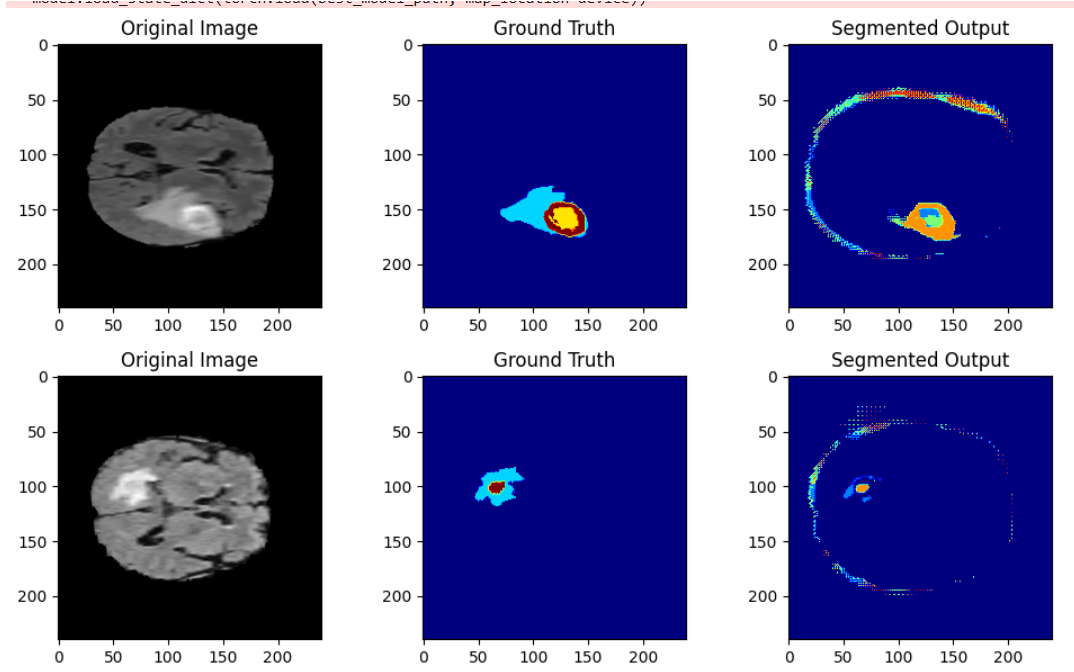

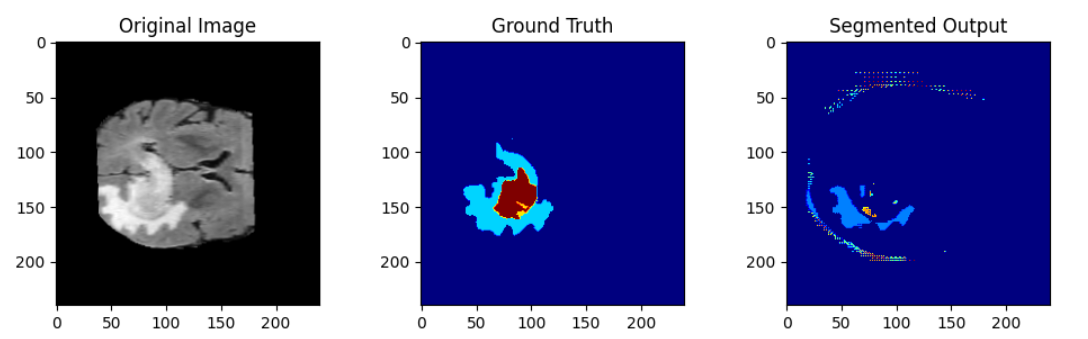

# Batch Size = 12 ----> Epoch 10 ---> 5 fold --> 30 Images

In [ ]:
# # # Batch Size = 12 ----> Epoch 10 ---> 5 fold --> 30 Images
# **************Training Subject functions loaded successfully!********************
# **************Evaluating the best model done********************
# Using device: cuda
# Found 484 image files.
# Found 484 label files.
# Demo mode: Using only 30 subjects.
# Model will use 4 input channels.

# === Fold 1/5 ===
# Epoch 1/10

#   Train Loss: 0.7426 | Val WT Dice: 0.6011
# Epoch 2/10

#   Train Loss: 0.3048 | Val WT Dice: 0.7349
# Epoch 3/10

#   Train Loss: 0.1474 | Val WT Dice: 0.7333
# Epoch 4/10

#   Train Loss: 0.0849 | Val WT Dice: 0.7188
# Epoch 5/10

#   Train Loss: 0.0561 | Val WT Dice: 0.8341
# Epoch 6/10

#   Train Loss: 0.0398 | Val WT Dice: 0.8255
# Epoch 7/10

#   Train Loss: 0.0295 | Val WT Dice: 0.8365
# Epoch 8/10

#   Train Loss: 0.0236 | Val WT Dice: 0.8276
# Epoch 9/10

#   Train Loss: 0.0189 | Val WT Dice: 0.8734
# Epoch 10/10

#   Train Loss: 0.0156 | Val WT Dice: 0.8488
# Fold 1 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.8017931676731054, 'HD95': 3.3981130251713894}, 'WT': {'Dice': 0.8487664453728512, 'HD95': 2.9349940334982}}

# === Fold 2/5 ===
# Epoch 1/10

#   Train Loss: 0.7448 | Val WT Dice: 0.6411
# Epoch 2/10

#   Train Loss: 0.2883 | Val WT Dice: 0.6727
# Epoch 3/10

#   Train Loss: 0.1397 | Val WT Dice: 0.5785
# Epoch 4/10

#   Train Loss: 0.0808 | Val WT Dice: 0.6498
# Epoch 5/10

#   Train Loss: 0.0528 | Val WT Dice: 0.7799
# Epoch 6/10

#   Train Loss: 0.0372 | Val WT Dice: 0.7668
# Epoch 7/10

#   Train Loss: 0.0280 | Val WT Dice: 0.7940
# Epoch 8/10

#   Train Loss: 0.0224 | Val WT Dice: 0.8359
# Epoch 9/10

#   Train Loss: 0.0181 | Val WT Dice: 0.8320
# Epoch 10/10

#   Train Loss: 0.0151 | Val WT Dice: 0.7808
# Fold 2 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7567010331302743, 'HD95': 5.4444287251302566}, 'WT': {'Dice': 0.7808289059972444, 'HD95': 5.0951449963266535}}

# === Fold 3/5 ===
# Epoch 1/10

#   Train Loss: 0.8479 | Val WT Dice: 0.7129
# Epoch 2/10

#   Train Loss: 0.3282 | Val WT Dice: 0.7765
# Epoch 3/10

#   Train Loss: 0.1671 | Val WT Dice: 0.7838
# Epoch 4/10

#   Train Loss: 0.0990 | Val WT Dice: 0.8003
# Epoch 5/10

#   Train Loss: 0.0639 | Val WT Dice: 0.8409
# Epoch 6/10

#   Train Loss: 0.0443 | Val WT Dice: 0.8323
# Epoch 7/10

#   Train Loss: 0.0332 | Val WT Dice: 0.8472
# Epoch 8/10

#   Train Loss: 0.0251 | Val WT Dice: 0.8193
# Epoch 9/10

#   Train Loss: 0.0214 | Val WT Dice: 0.8595
# Epoch 10/10

#   Train Loss: 0.0177 | Val WT Dice: 0.8620
# Fold 3 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.8068723484814349, 'HD95': 4.509523899100993}, 'WT': {'Dice': 0.8619580080632371, 'HD95': 3.6683851100824105}}

# === Fold 4/5 ===
# Epoch 1/10

#   Train Loss: 0.8811 | Val WT Dice: 0.5890
# Epoch 2/10

#   Train Loss: 0.3402 | Val WT Dice: 0.7714
# Epoch 3/10

#   Train Loss: 0.1556 | Val WT Dice: 0.7901
# Epoch 4/10

#   Train Loss: 0.0817 | Val WT Dice: 0.7823
# Epoch 5/10

#   Train Loss: 0.0504 | Val WT Dice: 0.8378
# Epoch 6/10

#   Train Loss: 0.0341 | Val WT Dice: 0.8418
# Epoch 7/10

#   Train Loss: 0.0260 | Val WT Dice: 0.8239
# Epoch 8/10

#   Train Loss: 0.0202 | Val WT Dice: 0.8803
# Epoch 9/10

#   Train Loss: 0.0163 | Val WT Dice: 0.8573
# Epoch 10/10

#   Train Loss: 0.0140 | Val WT Dice: 0.8140
# Fold 4 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7277684248961873, 'HD95': 3.8043080897744908}, 'WT': {'Dice': 0.8140384848287451, 'HD95': 2.6139822909714483}}

# === Fold 5/5 ===
# Epoch 1/10

#   Train Loss: 0.7406 | Val WT Dice: 0.6842
# Epoch 2/10

#   Train Loss: 0.2863 | Val WT Dice: 0.7255
# Epoch 3/10

#   Train Loss: 0.1389 | Val WT Dice: 0.7928
# Epoch 4/10

#   Train Loss: 0.0796 | Val WT Dice: 0.8063
# Epoch 5/10

#   Train Loss: 0.0513 | Val WT Dice: 0.8093
# Epoch 6/10

#   Train Loss: 0.0365 | Val WT Dice: 0.8037
# Epoch 7/10

#   Train Loss: 0.0273 | Val WT Dice: 0.7851
# Epoch 8/10

#   Train Loss: 0.0217 | Val WT Dice: 0.8248
# Epoch 9/10

#   Train Loss: 0.0178 | Val WT Dice: 0.8425
# Epoch 10/10

#   Train Loss: 0.0148 | Val WT Dice: 0.8259
# Fold 5 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7858879595528346, 'HD95': 3.664678520087207}, 'WT': {'Dice': 0.825873884812139, 'HD95': 2.8305265916419318}}

# Summary of Cross Validation Results:
# Fold	ET Dice	ET HD95	TC Dice	TC HD95	WT Dice	WT HD95
# 1	1.0000	0.0000	0.8018	3.3981	0.8488	2.9350
# 2	1.0000	0.0000	0.7567	5.4444	0.7808	5.0951
# 3	1.0000	0.0000	0.8069	4.5095	0.8620	3.6684
# 4	1.0000	0.0000	0.7278	3.8043	0.8140	2.6140
# 5	1.0000	0.0000	0.7859	3.6647	0.8259	2.8305

# Average Results (across folds):
# ET Dice: 1.0000, ET HD95: 0.0000
# TC Dice: 0.7758, TC HD95: 4.1642
# WT Dice: 0.8263, WT HD95: 3.4286
# fOR EVALUATION Model will use 4 input channels.
# Loading best model from: best_model_fold3.pth


## Output of the above code execution

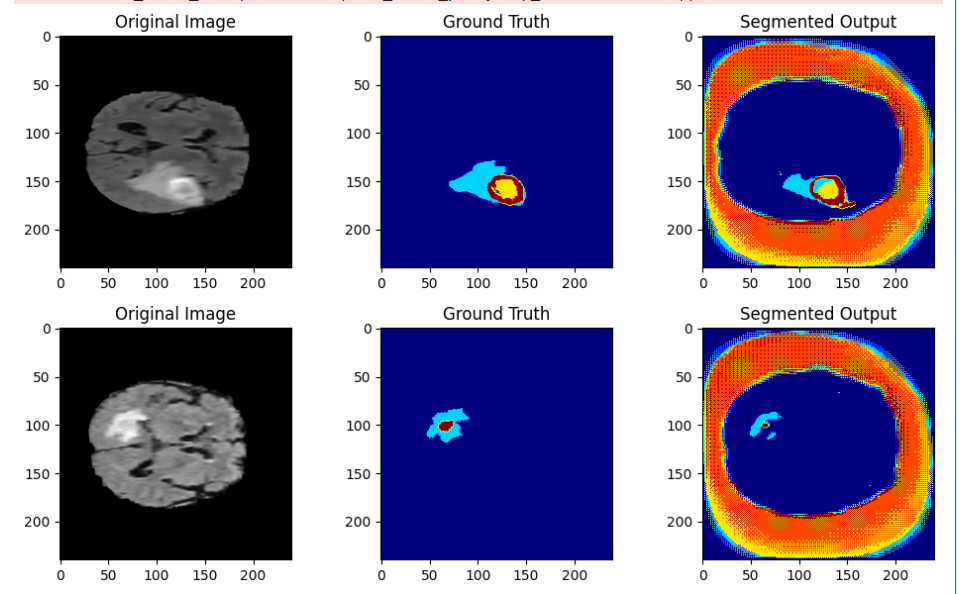

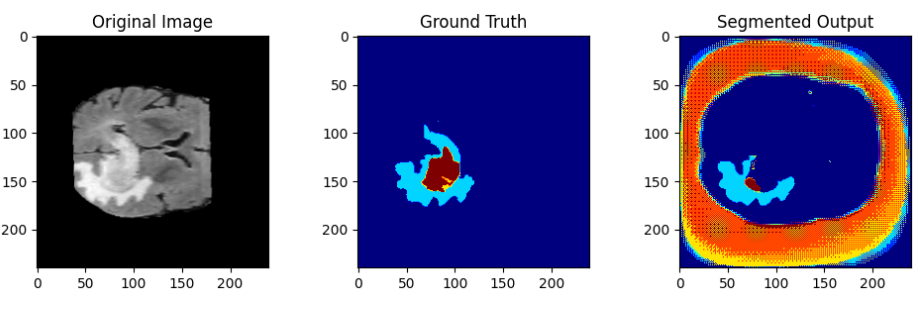

## Batch Size = 12 ----> Epoch 5 ---> 5 fold and 48 Images Results executed with Same code different parameter values

In [ ]:
# ### Tested with more Epoch results are below :
# # Batch Size = 12 ----> Epoch 5 ---> 5 fold
# **************Training Subject functions loaded successfully!********************
# **************Evaluating the best model done********************
# Using device: cuda
# Found 484 image files.
# Found 484 label files.
# Demo mode: Using only 48 subjects.
# Model will use 4 input channels.

# === Fold 1/5 ===
# Epoch 1/5

#   Train Loss: 0.5997 | Val WT Dice: 0.7345
# Epoch 2/5

#   Train Loss: 0.1596 | Val WT Dice: 0.7596
# Epoch 3/5

#   Train Loss: 0.0663 | Val WT Dice: 0.7920
# Epoch 4/5

#   Train Loss: 0.0392 | Val WT Dice: 0.8210
# Epoch 5/5

#   Train Loss: 0.0274 | Val WT Dice: 0.8419
# Fold 1 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.7872770484208426, 'HD95': 4.612725847116132}, 'WT': {'Dice': 0.8418682225781847, 'HD95': 4.145108247180752}}

# === Fold 2/5 ===
# Epoch 1/5

#   Train Loss: 0.7142 | Val WT Dice: 0.6247
# Epoch 2/5

#   Train Loss: 0.1814 | Val WT Dice: 0.7411
# Epoch 3/5

#   Train Loss: 0.0754 | Val WT Dice: 0.7803
# Epoch 4/5

#   Train Loss: 0.0400 | Val WT Dice: 0.7492
# Epoch 5/5

#   Train Loss: 0.0259 | Val WT Dice: 0.8423
# Fold 2 final metrics: {'ET': {'Dice': 0.9993548451612257, 'HD95': 0.0}, 'TC': {'Dice': 0.7819204464196993, 'HD95': 4.869921676200728}, 'WT': {'Dice': 0.8422863162305232, 'HD95': 3.940186385410905}}

# === Fold 3/5 ===
# Epoch 1/5

#   Train Loss: 0.4234 | Val WT Dice: 0.6337
# Epoch 2/5

#   Train Loss: 0.1069 | Val WT Dice: 0.6822
# Epoch 3/5

#   Train Loss: 0.0492 | Val WT Dice: 0.7229
# Epoch 4/5

#   Train Loss: 0.0303 | Val WT Dice: 0.7899
# Epoch 5/5

#   Train Loss: 0.0212 | Val WT Dice: 0.7434
# Fold 3 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.70647430260785, 'HD95': 7.672232235328828}, 'WT': {'Dice': 0.7434123797342876, 'HD95': 7.849417093445121}}

# === Fold 4/5 ===
# Epoch 1/5

#   Train Loss: 0.5412 | Val WT Dice: 0.7785
# Epoch 2/5

#   Train Loss: 0.1448 | Val WT Dice: 0.7036
# Epoch 3/5

#   Train Loss: 0.0664 | Val WT Dice: 0.7906
# Epoch 4/5

#   Train Loss: 0.0374 | Val WT Dice: 0.7920
# Epoch 5/5

#   Train Loss: 0.0262 | Val WT Dice: 0.8205
# Fold 4 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.774867112331671, 'HD95': 3.1024735275310724}, 'WT': {'Dice': 0.820472966647634, 'HD95': 2.686093399837007}}

# === Fold 5/5 ===
# Epoch 1/5

#   Train Loss: 0.5570 | Val WT Dice: 0.7515
# Epoch 2/5

#   Train Loss: 0.1242 | Val WT Dice: 0.7304
# Epoch 3/5

#   Train Loss: 0.0547 | Val WT Dice: 0.8316
# Epoch 4/5

#   Train Loss: 0.0327 | Val WT Dice: 0.8036
# Epoch 5/5

#   Train Loss: 0.0231 | Val WT Dice: 0.8420
# Fold 5 final metrics: {'ET': {'Dice': 1.0, 'HD95': 0.0}, 'TC': {'Dice': 0.8174514503164687, 'HD95': 3.946552630266137}, 'WT': {'Dice': 0.8419839616183932, 'HD95': 3.617001779263601}}

# Summary of Cross Validation Results:
# Fold	ET Dice	ET HD95	TC Dice	TC HD95	WT Dice	WT HD95
# 1	1.0000	0.0000	0.7873	4.6127	0.8419	4.1451
# 2	0.9994	0.0000	0.7819	4.8699	0.8423	3.9402
# 3	1.0000	0.0000	0.7065	7.6722	0.7434	7.8494
# 4	1.0000	0.0000	0.7749	3.1025	0.8205	2.6861
# 5	1.0000	0.0000	0.8175	3.9466	0.8420	3.6170

# Average Results (across folds):
# ET Dice: 0.9999, ET HD95: 0.0000
# TC Dice: 0.7736, TC HD95: 4.8408
# WT Dice: 0.8180, WT HD95: 4.4476
# fOR EVALUATION Model will use 4 input channels.
# Loading best model from: best_model_fold2.pth

# output of the above execution

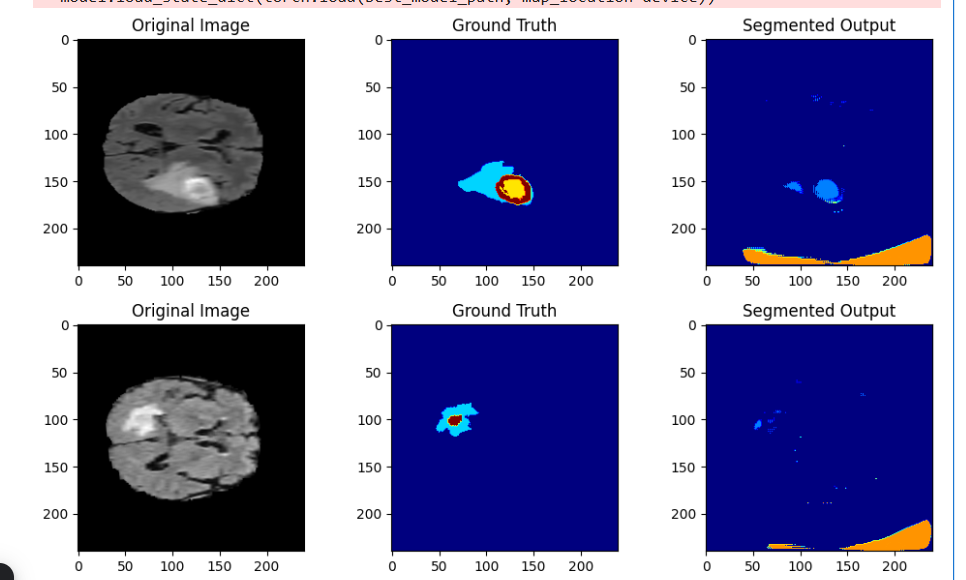

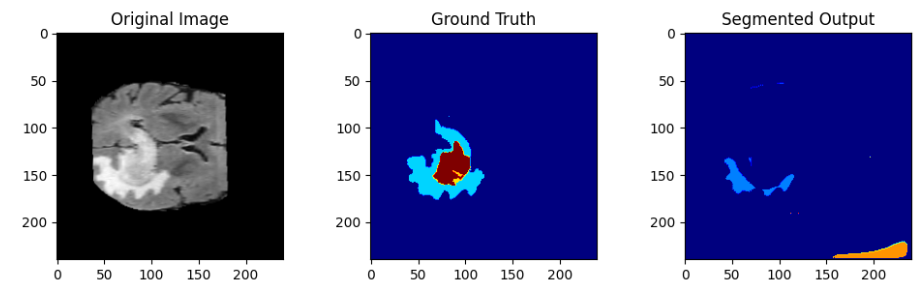